Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]


Epoch [1/10], Loss: 0.0841
Epoch [2/10], Loss: 0.0673
Epoch [3/10], Loss: 0.0651
Epoch [4/10], Loss: 0.0639
Epoch [5/10], Loss: 0.0631
Epoch [6/10], Loss: 0.0625
Epoch [7/10], Loss: 0.0620
Epoch [8/10], Loss: 0.0616
Epoch [9/10], Loss: 0.0613
Epoch [10/10], Loss: 0.0610
Training Finished
Noisy Image


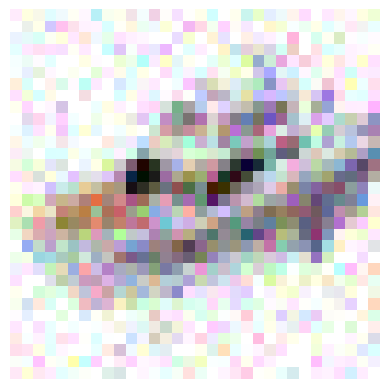

Reconstructed Image


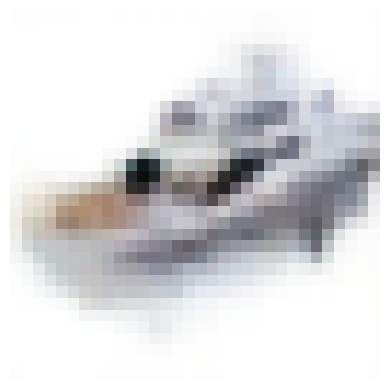

Original Image


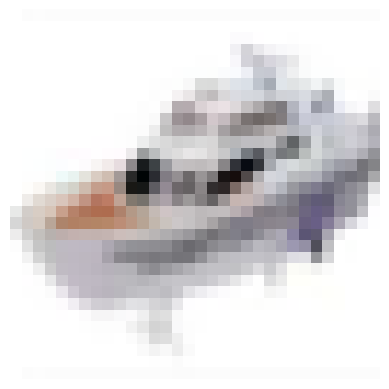

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# =============================
# 1. Device Configuration
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =============================
# 2. Load CIFAR10 Dataset
# =============================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))   # Normalize to [-1, 1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

# =============================
# 3. Add Noise Function
# =============================
def add_noise(images):
    noise = torch.randn_like(images) * 0.2
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, -1., 1.)
    return noisy_images

# =============================
# 4. Encoder-Decoder Model
# =============================
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()   # Output in [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)

# =============================
# 5. Loss and Optimizer
# =============================
criterion = nn.L1Loss()      # You can change to nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =============================
# 6. Training
# =============================
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0

    for images, _ in trainloader:
        images = images.to(device)

        noisy_images = add_noise(images)

        outputs = model(noisy_images)

        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {running_loss/len(trainloader):.4f}")

print("Training Finished")

# =============================
# 7. Visualization
# =============================
dataiter = iter(trainloader)
images, _ = next(dataiter)

images = images.to(device)
noisy_images = add_noise(images)
outputs = model(noisy_images)

# Move to CPU for plotting
images = images.cpu().detach()
noisy_images = noisy_images.cpu().detach()
outputs = outputs.cpu().detach()

def imshow(img):
    img = img / 2 + 0.5     # Convert [-1,1] to [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

print("Noisy Image")
imshow(noisy_images[0])

print("Reconstructed Image")
imshow(outputs[0])

print("Original Image")
imshow(images[0])